Deze documentatie is gegenereerd via een Jupyter Notebook. Je kunt deze notebook downloaden via [GitHub](https://github.com/d2hydro/lhm-ribasim/blob/main/notebooks/bouw_lhm_topology.ipynb) en de RIBASIM topologie nabouwen.

## Aanpak
1) LSWs routen naar benedenstroomse LSWs
   Aanname:
   - We gaan ervan uit dat LSWs die afwateren op andere LSWs níet tevens afwateren op het DM.
   Resultaat:
   2309 LSW eindpunten moeten gekoppeld worden aan DM knopen
2) LSW eindpunten naar 1 unieke DM-knoop
   Methode:
   - Check voor iedere LSW eindpunt het bijbehorende district
   - Check welke districten aan slechts 1 DM-knoop worden gekoppeld door uitlezen van dwkeys.txt
   Resultaat:
   1784 LSWs gekoppeld aan DM-knopen
3) LSW eindpunten naar DM-knopen via LSM-lateralen:
   Data:
   - We hebben een routing LKM file (LKM25_links) die de afvoerrichting naar LKM netwerk weergeeft (blauwe pijlen in de figuur)
   - We hebben een LKM waterlichamen file (lkm_waterlichamen_shp) (rode polygonen in de figuur)
   - We hebben een LSM3 lateraal file (LSM3_DMKnoopDistrict_childs.csv) die aangeeft welke LSM3 lateral aan DM knoop is gekoppeld (groene punten in de figuur)
   Methode:
   1. We volgen de routing in de LKM file van de LSW eindpunten tot deze uitkomt in een LKM waterlichaam.   
   2. We zoeken de dichtsbijzijnde LSM3 lateraal van het LKM waterlichaam
   3. We lezen de bijbehorende DM knoop uit de LSM3_DMKnoopDistrict_childs.csv
   Resultaat: 457 LSWs koppelingen gemaakt aan DM-knopen
   
   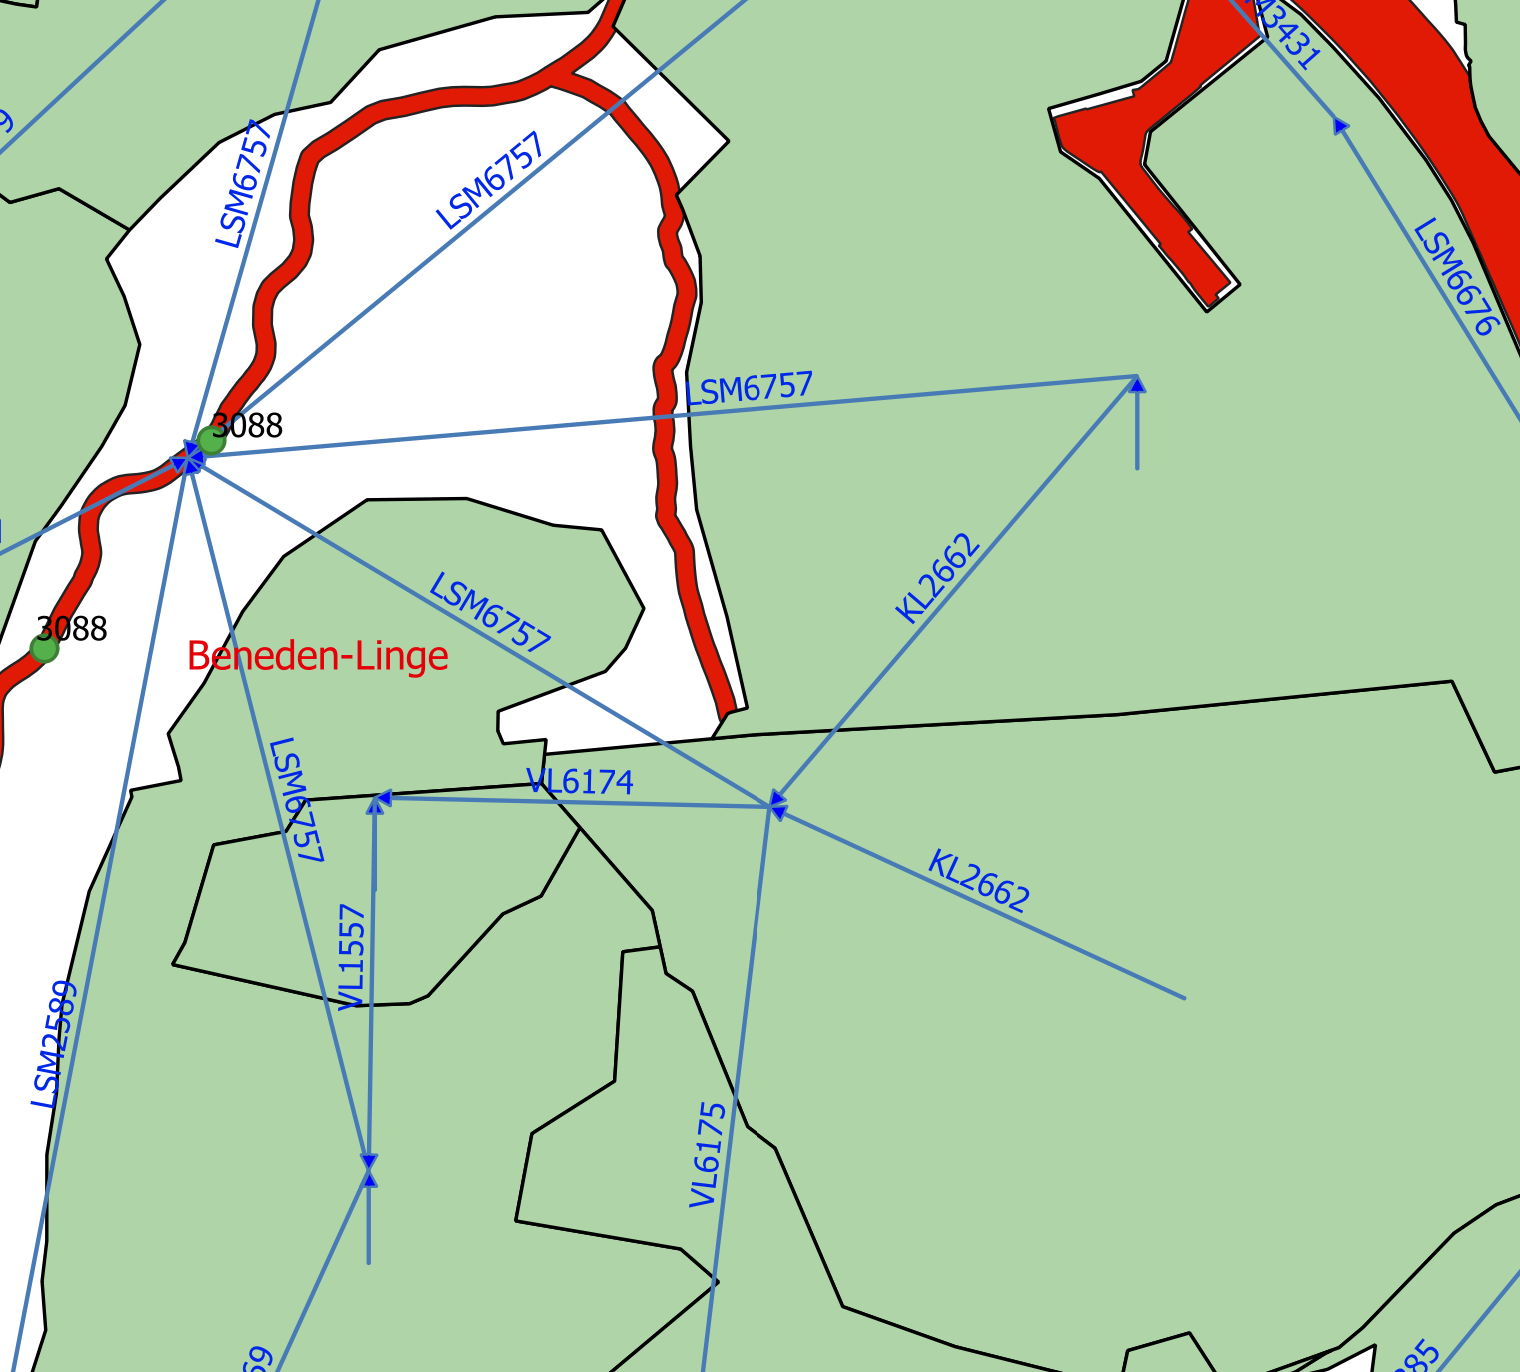
   
4) LSW eindpunten naar dichtsbijzijnde DM-knoop:

   De LSW eindpunten die overblijven (193) koppelen we aan de dichtsbijzijnde DM-knoop

In [ ]:
from config import DATA_DIR, LKM25_DIR, MOZART_DIR, LHM_DIR, LSW_DIR, LSM_KOPPELING_DIR, load_src
import geopandas as gpd
load_src()

from lhm.dm import find_unique_dm_links, find_routing_to_dm_links, find_shortest_dm_links, links_to_geodataframe
from lhm.read import read_lsm_lhm, read_lsw_routing, read_dw_keys
from lhm.lsm import snap_to_waterbodies
from lhm.lsw import lsw_end_nodes, lsw_network

## 1. LSWs routen naar benedenstroomse LSWs

### LSW-naar-LSW netwerk
Vanuit de geleverde `lsws.shp` en `lswrouting.dik` maken we een netwerk van LSWs.

In [ ]:
lsw_routing_dik = MOZART_DIR / r"mozartin/lswrouting.dik"
lsw_routing_df = read_lsw_routing(lsw_routing_dik)
lsw_gdf = gpd.read_file(LSW_DIR / "lsws.shp")

lsw_gdf = lsw_gdf.dissolve(by="LSWFINAL").reset_index()
lsw_links_gdf, lsw_nodes_gdf = lsw_network(lsw_gdf, lsw_routing_df)

### LSW eindpunten

We gaan ervan uit dat LSWs die afwateren op andere LSWs níet tevens afwateren op het DM. We gaan vanaf dit punt LSWs die niet gekoppeld zijn aan andere LSWs koppelen aan het DM. Hieronder tonen we deze LSWs op de kaart

In [ ]:
# Bepalen lsw-knopen die gekoppeld moeten worden aan een DM-knoop
lsw_end_nodes_gdf = lsw_end_nodes(lsw_links_gdf, lsw_gdf)
print(f"we moeten {len(lsw_end_nodes_gdf)} koppelen aan DM-knopen")
lsw_end_nodes_gdf.explore()

## 2. LSW eindpunten naar 1 unieke DM-knoop

Vanuit `dwkeys.txt`kunnen we per district kijken aan welke DM knoop wordt gekoppeld. Wanneer een district slechts koppelt aan 1 DM-knoop, dan betekent dit dat alle LSWs in dit district gekoppeld moeten worden aan deze knoop.

We doen dit en tonen de overgebleven nog niet gekoppelde LSWs.

In [ ]:
# Inlezen DW-keys file
dw_key_file = LHM_DIR / r"dm/txtfiles_git/dwkeys.txt"
dw_keys_df = read_dw_keys(dw_key_file)

# Inlezen LSW-netwerk
lsw_dm_links = find_unique_dm_links(lsw_end_nodes_gdf, dw_keys_df)

# Tonen resultaat
print(f"{len(lsw_dm_links)} LSWs gekoppeld aan DM-knopen")
lsw_end_nodes_gdf = lsw_end_nodes_gdf.loc[~lsw_end_nodes_gdf.LSWFINAL.isin([i[0] for i in lsw_dm_links])]
print(f"We moeten nog {len(lsw_end_nodes_gdf)} koppelen aan DM-knopen")
lsw_end_nodes_gdf.explore()

## 3. LSW eindpunten naar DM-knopen via LSM-lateralen

Vanuit de bestanden `LSM3_locations.csv`, `LSM3_DMKnoopDistrict_childs.csv` kunnen we uitzoeken hoe aan welke DM-knoop een LSM-lateraal is gekoppeld. Een LSM-lateraal ligt meestal vrij netjes in het watersysteem geschematiseerd.

In [ ]:
# Inlezen LSM3-DM csv-bestanden
lsm3_locations_csv = LSM_KOPPELING_DIR / "LSM3_locations.csv"
knoop_district_csv = LSM_KOPPELING_DIR / "LSM3_DMKnoopDistrict_childs.csv"

# Tonen LSM lateralen met DM-knoopinformatie
lsm_lhm_gdf = read_lsm_lhm(lsm3_locations_csv, knoop_district_csv)
lsm_lhm_gdf.explore()

### Koppelen LSW via LSM-lateralen aan DM
Voor de nog overgebleven LSWs zoeken we de DM-knoop via LSM-lateralen. We nemen deze stappen:
1. We kijken of er LSM-lateralen van het juist district liggen in het gebied van de LSW
2. We kijken aan welke unieke DM-knopen deze lateralen zijn verbonden. We verbinden de LSW met al deze districten

In [ ]:
# inlezen LKM-waterlichamen en LKM-links
lkm_waterlichamen_shp = LKM25_DIR / "KRW-waterlichamen_SGBP3.shp"
lkm_waterlichamen_gdf = gpd.read_file(lkm_waterlichamen_shp)

lkm_links_shp = LKM25_DIR / "LKM25_Links.shp"
lkm_links_gdf = gpd.read_file(lkm_links_shp)

In [ ]:
# zoeken naar nieuwe lsw-dm-links
_lsw_dm_links = find_routing_to_dm_links(
    lsw_end_nodes_gdf,
    lsw_gdf,
    dw_keys_df,
    lkm_links_gdf,
    lsm_lhm_gdf,
    lkm_waterlichamen_gdf
)

# Tonen resultaat
lsw_dm_links += _lsw_dm_links
print(f"{len(_lsw_dm_links)} LSWs koppelingen gemaakt aan DM-knopen") 
lsw_end_nodes_gdf = lsw_end_nodes_gdf.loc[~lsw_end_nodes_gdf.LSWFINAL.isin([i[0] for i in _lsw_dm_links])]
print(f"We moeten {len(lsw_end_nodes_gdf)} koppelen aan DM-knopen")
lsw_end_nodes_gdf.explore()

## 4. LSW eindpunten naar dichtsbijzijnde DM-knoop

Als uiterste mogelijkheid koppelen we LSW-knopen aan de meest dichtbijzijnde DM-knoop die voorkomt in de DM-keys

In [ ]:
# DM-knopen en -links inlezen
dm_nodes_shp = LHM_DIR / r"dm/data_dvc/DM_nodes.shp"
dm_links_shp = LHM_DIR / r"dm/data_dvc/DM_links.shp"

dm_nodes_gdf = gpd.read_file(dm_nodes_shp)
dm_links_gdf = gpd.read_file(dm_links_shp)

dm_nodes_gdf.columns = [i.strip() for i in dm_nodes_gdf.columns]
dm_links_gdf.columns = [i.strip() for i in dm_links_gdf.columns]

# Zoeken naar nieuwe DM-links
_lsw_dm_links = find_shortest_dm_links(lsw_end_nodes_gdf, dw_keys_df, dm_nodes_gdf)

# Tonen resultaat
lsw_dm_links += _lsw_dm_links
print(f"{len(_lsw_dm_links)} LSWs koppelingen gemaakt aan DM-knopen") 
lsw_end_nodes_gdf = lsw_end_nodes_gdf.loc[~lsw_end_nodes_gdf.LSWFINAL.isin([i[0] for i in _lsw_dm_links])]
print(f"We moeten {len(lsw_end_nodes_gdf)} koppelen aan DM-knopen")

## 5. Resultaat

In de kaart hieronder zie je het resultaat

In [ ]:
# lsw-dm-links naar een geodataframe
lsw_dm_links_gdf = links_to_geodataframe(lsw_dm_links, lsw_nodes_gdf, dm_nodes_gdf)

In [ ]:
# Tonen kaart
import folium
m = lsw_links_gdf.explore(name="lsw links", color="blue")
m = lsw_dm_links_gdf.explore(m=m, name="lsw-dm links", color="green")
m = dm_links_gdf.explore(m=m, name="dm links", color="red")

folium.LayerControl().add_to(m)

m